# Topic Modeling

As part of our research into public sentiment regarding Maserati's move towards electrification, we employed Latent Dirichlet Allocation (LDA) to analyze social media comments. Our analysis aimed to identify the main topics of discussion and understand how these topics are distributed across the entire dataset. The results are presented in two parts: the characterization of individual topics and the distribution of dominant topics.

In [1]:
# Import library
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary


/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `sci

In [2]:
df = pd.read_excel('../SentimentalAgeCombined.xlsx')


### Method 1 (Using scikit-learn):
This code uses scikit-learn's Latent Dirichlet Allocation (LDA) for topic modeling and has a simpler preprocessing approach.

In [3]:
# Load the English language small model of SpaCy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Preprocesses the text by converting to lowercase, splitting, removing non-alphanumeric words, and filtering out stop words
def preprocess_text(text):
    return ' '.join([word for word in text.lower().split() if word.isalpha() and word not in sw_spacy and len(word) > 2])

df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


# # Transform into a bag of words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(df['ProcessedComment'])

# # Train the LDA model
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(data_vectorized)

# # Display Topic
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))



Topic 1:
car electric version maserati petrol interior think nice tesla look
Topic 2:
maserati car engine new better cars italian like good old
Topic 3:
electric car maserati love sound buy going want engine cars
Topic 4:
maserati beautiful best car gran sound years turismo price noise
Topic 5:
like looks maserati design electric good ferrari cars beautiful better


### Plot the Topics in LDA Model

Topic 1: If the top words include terms related to electric vehicles, battery life, and charging, this topic might be about the technical aspects of Maserati's move towards electrification.
Topic 2: If the words are related to design, luxury, and brand image, this topic might be about Maserati's brand perception and design philosophy.
Topic 3: If the words are related to performance, speed, and handling, this topic might focus on the performance attributes of Maserati's electric vehicles.
Topic 4: If the words include terms like price, value, and affordability, this topic might be about the cost and value proposition of Maserati's electric vehicles.

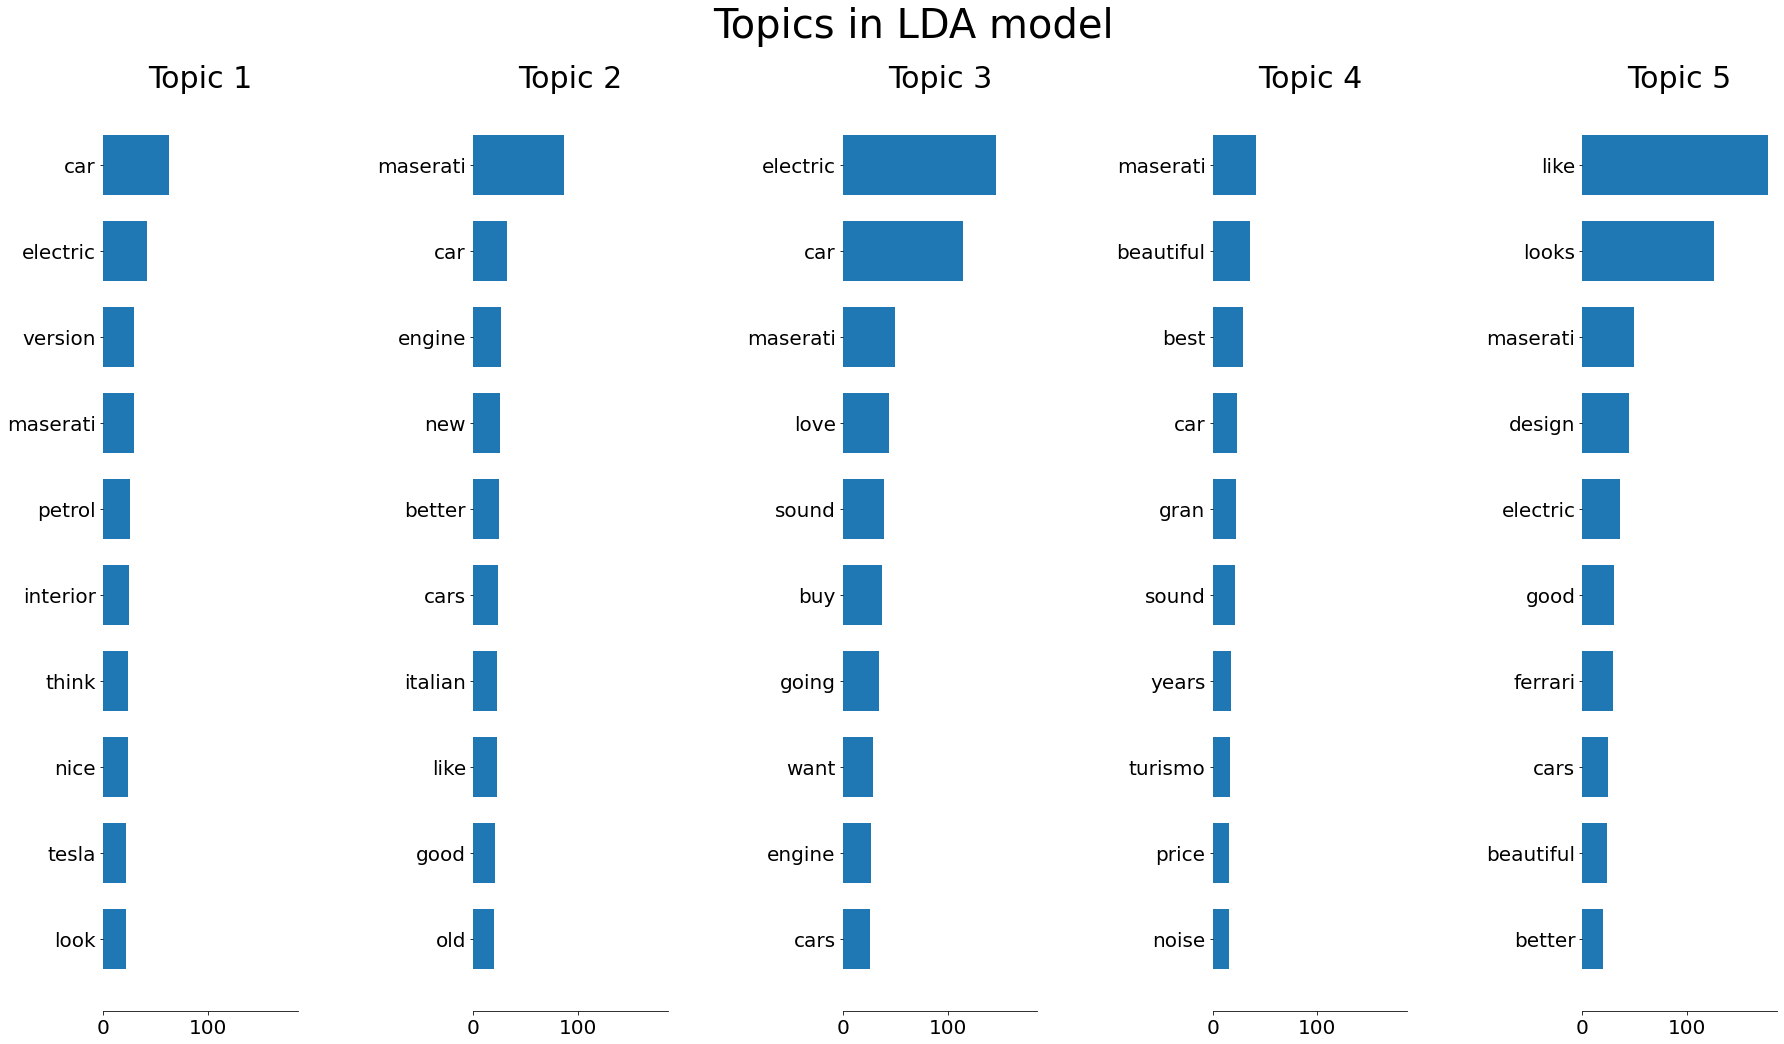

In [8]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, num_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.suptitle(title, fontsize=40)

# Call the function to plot the top words in each topic
plot_top_words(lda_model, feature_names, 10, 'Topics in LDA model')


### Method 2 (Using Gensim):
This code uses the Gensim library for topic modeling and includes several preprocessing steps.
<br>The code is provided by https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

### Build the Bigram, Trigram Models and Lemmatize

In [11]:
def preprocess_text(text):
    return ' '.join([word for word in text.lower().split() if word.isalpha() and word not in sw_spacy and len(word) > 2])

df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)

import re
import gensim

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data = df['ProcessedComment'].values.tolist()
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=sw_spacy, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        # remove stopwords once more after lemmatization
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)

<>:11: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \s
/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/3989949920.py:11: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/3989949920.py:12: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


### Build the Topic Model

In [12]:
from gensim.corpora import Dictionary

# Create Dictionary
id2word = Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

print(lda_model.print_topics())



[(0, '0.104*"car" + 0.072*"look" + 0.028*"electric" + 0.021*"design" + 0.017*"drive" + 0.012*"absolutely" + 0.012*"thing" + 0.011*"interior" + 0.011*"bad" + 0.011*"version"'), (1, '0.024*"know" + 0.021*"engine" + 0.021*"charge" + 0.020*"buy" + 0.018*"come" + 0.016*"ice" + 0.016*"issue" + 0.015*"center" + 0.013*"price" + 0.012*"review"'), (2, '0.045*"new" + 0.037*"sound" + 0.030*"old" + 0.028*"work" + 0.024*"good" + 0.014*"way" + 0.012*"problem" + 0.010*"wheel" + 0.010*"resemble" + 0.009*"lol"'), (3, '0.034*"need" + 0.031*"lot" + 0.026*"year" + 0.024*"think" + 0.015*"model" + 0.014*"feel" + 0.013*"watch" + 0.012*"point" + 0.011*"supply" + 0.009*"video"')]


### Dominant topic and its percentage contribution in each document

In [15]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Initialize output list
    sent_topics_data = []

    # Iterate through each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: x[1], reverse=True)

        # Get the dominant topic, percentage contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_data.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break

    # Create DataFrame
    sent_topics_df = pd.DataFrame(sent_topics_data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_topic_sents_keywords.reset_index(inplace=True)
df_topic_sents_keywords.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_topic_sents_keywords.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8859,"know, engine, charge, buy, come, ice, issue, center, price, review","[speed, limit, italian, know, love, visual]"
1,1,1,0.4691,"know, engine, charge, buy, come, ice, issue, center, price, review","[honestly, need, moving, think, hit, forget, magic]"
2,2,0,0.2500,"car, look, electric, design, drive, absolutely, thing, interior, bad, version",[]
3,3,0,0.6249,"car, look, electric, design, drive, absolutely, thing, interior, bad, version",[mean]
4,4,0,0.5550,"car, look, electric, design, drive, absolutely, thing, interior, bad, version","[feel, smile, reaction, beautiful, exhaust_note]"
5,5,3,0.4494,"need, lot, year, think, model, feel, watch, point, supply, video","[thank, simply, bliss]"
6,6,3,0.2557,"need, lot, year, think, model, feel, watch, point, supply, video","[time, watch, channel, disappoint]"
7,7,3,0.8383,"need, lot, year, think, model, feel, watch, point, supply, video","[feel, cold, weather, voice]"
8,8,0,0.7982,"car, look, electric, design, drive, absolutely, thing, interior, bad, version","[chill, bone, light]"
9,9,0,0.6250,"car, look, electric, design, drive, absolutely, thing, interior, bad, version",[beautiful]


In [16]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9457,"car, look, electric, design, drive, absolutely, thing, interior, bad, version","[nice, shame, alfieri, production, car, prettiest, car, bring, drive, spare, drive, car, wash]"
1,1,0.9142,"know, engine, charge, buy, come, ice, issue, center, price, review","[public, charger, western, find, charger, map, know, find]"
2,2,0.9240,"new, sound, old, work, good, way, problem, wheel, resemble, lol","[admit, skill, share, print, problem, wish, touch, obviously, natural, skill, fair, touch, lively]"
3,3,0.8991,"need, lot, year, think, model, feel, watch, point, supply, video","[modern, maseratis, tell, giant, lemon, electrical, fault]"


### The most representative sentence for each topic

In [11]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model.get_document_topics(corp)
        dominant_topic = sorted(topic_percs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([{topic: weight for topic, weight in tp} for tp in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, ", ".join([word for word, _ in lda_model.show_topic(i, topn=3)])) for i in range(lda_model.num_topics)]

df_top3words = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])


## Visualisation

### Plot the Distribution of Dominant Topics

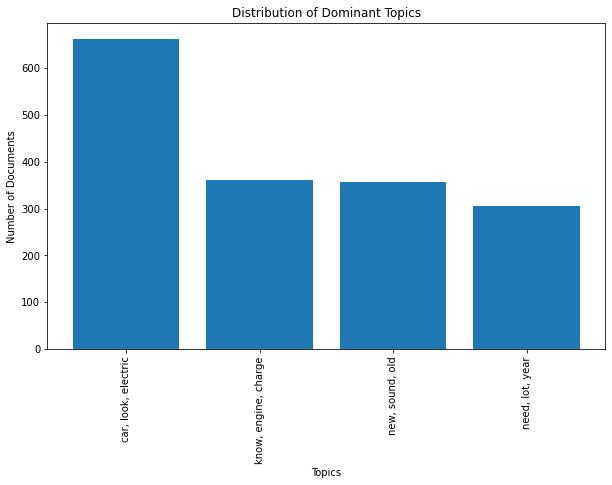

In [12]:
import matplotlib.pyplot as plt

# Merge the DataFrames to include the top 3 keywords for each topic
df_dominant_topic_with_keywords = df_dominant_topic_in_each_doc.merge(df_top3words, left_on='Dominant_Topic', right_on='topic_id')

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_with_keywords)
plt.xticks(df_dominant_topic_with_keywords['Dominant_Topic'], df_dominant_topic_with_keywords['words'], rotation=90)
plt.xlabel('Topics')
plt.ylabel('Number of Documents')
plt.title('Distribution of Dominant Topics')
plt.show()


### The most discussed topics in the documents

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.244807 -0.026851       1        1  30.807575
3      0.056058  0.130349       2        1  24.998807
1      0.081019  0.102229       3        1  24.973562
2      0.107730 -0.205728       4        1  19.220055, topic_info=              Term        Freq       Total Category  logprob  loglift
42             car  276.000000  276.000000  Default  30.0000  30.0000
38            look  191.000000  191.000000  Default  29.0000  29.0000
58             new   75.000000   75.000000  Default  28.0000  28.0000
59           sound   61.000000   61.000000  Default  27.0000  27.0000
11            need   73.000000   73.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
2257  unmistakably   11.600563   13.502878   Topic4  -4.9603   1.4974
1025      mechanic   12.402203   23.971726   Topic4  -4.8935   0.9902
467         handle    7.727094   10.256822   Topic4  -5.3666   1.3660
300         wonder    7.708577   10.170908   Topic4  -5.3690   1.3720
2242           psa    8.105380   14.726667   Topic4  -5.3188   1.0521

[173 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
358       1  0.975464  absolutely
188       2  0.071366       agree
188       4  0.856387       agree
402       3  0.952018         air
429       4  0.956298        alfa
...     ...       ...         ...
300       3  0.098320      wonder
300       4  0.786557      wonder
375       3  0.021168        work
375       4  0.973722        work
148       2  0.983880        year

[186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [14]:
df_top3words

,topic_id,words
0,0,"car, look, electric"
1,1,"know, engine, charge"
2,2,"new, sound, old"
3,3,"need, lot, year"


# Second Topic Modelling for deeper analysis

### Topic Label for each age categories sentiment:

### 10s Negative Comments

In [19]:
filtered_df = df[(df['PredictedCategory'] == 10) & (df['EmotionRoberta'] == 0)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/3035293028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"think, years, like"
1,1,"electric, soul, overpriced"
2,2,"car, maserati, like"
3,3,"system, difference, business"


In [21]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.218581 -0.006688       1        1  35.564743
1     -0.085985 -0.149042       2        1  27.711874
0     -0.043892  0.054908       3        1  19.016710
3     -0.088704  0.100822       4        1  17.706673, topic_info=         Term       Freq      Total Category  logprob  loglift
28        car  76.000000  76.000000  Default  30.0000  30.0000
13        new  40.000000  40.000000  Default  29.0000  29.0000
4        like  57.000000  57.000000  Default  28.0000  28.0000
57   maserati  77.000000  77.000000  Default  27.0000  27.0000
14      sound  33.000000  33.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
169       old   5.982546  17.220299   Topic4  -4.8799   0.6740
62     people   3.904224  10.916008   Topic4  -5.3067   0.7031
80       cars   5.890859  38.120332   Topic4  -4.8954  -0.1361
20    exhaust   2.566388   5.602379   Topic4  -5.7263   0.9505
408    supply   2.406849   5.424910   Topic4  -5.7904   0.9185

[192 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
160       3  0.896034        able
507       1  0.950112  absolutely
507       2  0.028791  absolutely
351       1  0.951588    actually
212       1  0.978705         air
...     ...       ...         ...
291       4  0.657550        went
1025      3  0.764214       words
599       3  0.923462       worse
780       4  0.701037        year
141       3  0.902962       years

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

### 10s Positive Comments

In [22]:
filtered_df = df[(df['PredictedCategory'] == 10) & (df['EmotionRoberta'] == 1)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/1278528931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"like, looks, car"
1,1,"electric, maserati, need"
2,2,"maserati, engine, new"
3,3,"love, ferrari, maserati"


In [23]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.184360 -0.001887       1        1  31.951317
1     -0.064047 -0.165276       2        1  29.759926
2     -0.076471  0.089143       3        1  19.689374
3     -0.043842  0.078020       4        1  18.599383, topic_info=         Term       Freq      Total Category  logprob  loglift
146     looks  41.000000  41.000000  Default  30.0000  30.0000
125      like  70.000000  70.000000  Default  29.0000  29.0000
139    design  22.000000  22.000000  Default  28.0000  28.0000
34       love  28.000000  28.000000  Default  27.0000  27.0000
12       need  19.000000  19.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
86      sound   4.772997  23.551807   Topic4  -4.8774   0.0858
174      cars   4.205436  22.010017   Topic4  -5.0040   0.0269
72        car   4.484975  60.377590   Topic4  -4.9396  -0.9178
103  electric   3.676568  38.727377   Topic4  -5.1383  -0.6725
77     review   2.467905   7.603414   Topic4  -5.5370   0.5568

[217 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1309      4  0.659739    accept
199       1  0.935744  actually
185       4  0.810602      alfa
227       1  0.988630   alfieri
381       2  0.954189   amazing
...     ...       ...       ...
432       4  0.762679      work
765       3  0.836111     worry
958       3  0.797175       wow
198       1  0.147036     years
198       2  0.882217     years

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

### 20s Negative Comments

In [24]:
filtered_df = df[(df['PredictedCategory'] == 20) & (df['EmotionRoberta'] == 0)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/744225360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"maserati, electric, cars"
1,1,"car, let, chris"
2,2,"gear, car, good"
3,3,"electric, car, buy"


In [25]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.103087  0.085329       1        1  32.600326
2      0.143243  0.011272       2        1  26.171708
0     -0.054262 -0.124977       3        1  25.150378
1      0.014106  0.028376       4        1  16.077588, topic_info=         Term       Freq      Total Category  logprob  loglift
17   electric  26.000000  26.000000  Default  30.0000  30.0000
16        car  22.000000  22.000000  Default  29.0000  29.0000
161       buy  10.000000  10.000000  Default  28.0000  28.0000
4    maserati  10.000000  10.000000  Default  27.0000  27.0000
337      gear   4.000000   4.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
217     noise   1.592849   3.484322   Topic4  -4.4844   1.0450
16        car   3.373185  22.183264   Topic4  -3.7340  -0.0557
108   battery   0.928722   4.776058   Topic4  -5.0238   0.1902
447       big   0.835285   2.680649   Topic4  -5.1299   0.6617
501    months   0.776241   1.968229   Topic4  -5.2032   0.8973

[194 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
480       2  0.756317      admit
197       3  0.528392        age
406       1  0.678378  aggressiv
349       4  0.799512        amg
525       4  0.799541  announced
...     ...       ...        ...
27        2  0.365391       work
69        1  0.261304      years
69        3  0.261304      years
69        4  0.522608      years
335       4  0.799535    youtube

[194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

### 20s Positive Comments

In [26]:
filtered_df = df[(df['PredictedCategory'] == 20) & (df['EmotionRoberta'] == 1)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/1356996452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"car, electric, beautiful"
1,1,"know, thing, good"
2,2,"nice, maserati, design"
3,3,"electric, amazing, like"


In [27]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.135633 -0.037004       1        1  35.195519
2      0.006595 -0.043939       2        1  24.135634
3     -0.008226  0.128444       3        1  22.162892
1     -0.134002 -0.047502       4        1  18.505955, topic_info=         Term       Freq      Total Category  logprob  loglift
12        car  17.000000  17.000000  Default  30.0000  30.0000
37   electric  16.000000  16.000000  Default  29.0000  29.0000
164   amazing   4.000000   4.000000  Default  28.0000  28.0000
249     thing   3.000000   3.000000  Default  27.0000  27.0000
278      know   4.000000   4.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
353     sound   0.844481   1.350842   Topic4  -4.9372   1.2173
73       best   1.532178   2.518987   Topic4  -4.3414   1.1899
63       good   1.880842   6.805938   Topic4  -4.1364   0.4010
97        ice   1.188824   3.083733   Topic4  -4.5952   0.7339
20     engine   1.563875   6.418502   Topic4  -4.3210   0.2751

[187 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
321       1  0.622242  accomplishing
102       3  0.490105       actually
322       1  0.622242     advertised
164       3  0.825089        amazing
379       3  0.632192          astra
...     ...       ...            ...
240       3  0.649314           wait
124       2  0.495206           wish
124       3  0.495206           wish
167       3  0.649313            wow
36        3  0.982080           year

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

### 30s Negative Comments

In [28]:
filtered_df = df[(df['PredictedCategory'] == 30) & (df['EmotionRoberta'] == 0)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/3465236535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"puma, headlights, ford"
1,1,"maserati, able, owners"
2,2,"interior, look, horrible"
3,3,"sound, like, looks"


In [29]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.107490 -0.061627       1        1  36.557773
2     -0.032149  0.110270       2        1  24.741765
1      0.058704 -0.038580       3        1  20.119989
0      0.080935 -0.010063       4        1  18.580473, topic_info=           Term      Freq     Total Category  logprob  loglift
92     interior  2.000000  2.000000  Default  30.0000  30.0000
155        puma  1.000000  1.000000  Default  29.0000  29.0000
14   headlights  1.000000  1.000000  Default  28.0000  28.0000
154        ford  1.000000  1.000000  Default  27.0000  27.0000
23        looks  3.000000  3.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
171     obvious  0.603202  1.027094   Topic4  -4.3439   1.1508
170     alfieri  0.603195  1.027095   Topic4  -4.3439   1.1508
172      pretty  0.603190  1.027095   Topic4  -4.3439   1.1508
13      generic  0.603179  1.027096   Topic4  -4.3439   1.1508
70        panel  0.603220  1.528730   Topic4  -4.3439   0.7531

[170 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
87        2  0.912733     abit
79        3  0.646116     able
107       1  0.842478      add
144       1  0.842477      age
170       4  0.973620  alfieri
...     ...       ...      ...
94        2  0.912731     wont
143       4  0.973623    write
31        1  0.842478      yea
8         3  0.955939    years
188       3  0.955941    zvuka

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

### 30s Positive Comments

In [30]:
filtered_df = df[(df['PredictedCategory'] == 30) & (df['EmotionRoberta'] == 1)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/146941650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"looks, like, beautiful"
1,1,"maserati, better, reliable"
2,2,"maserati, god, granturismo"
3,3,"car, ford, fantastic"


In [31]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.129694  0.037287       1        1  33.208251
1      0.080103  0.088377       2        1  25.463901
2      0.037890 -0.029511       3        1  20.820687
3      0.011701 -0.096153       4        1  20.507161, topic_info=         Term       Freq      Total Category  logprob  loglift
9       looks   4.000000   4.000000  Default  30.0000  30.0000
60     better   2.000000   2.000000  Default  29.0000  29.0000
33   maserati  10.000000  10.000000  Default  28.0000  28.0000
41   reliable   2.000000   2.000000  Default  27.0000  27.0000
16       like   3.000000   3.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
74    awesome   0.663695   2.285127   Topic4  -4.6124   0.3480
69        job   0.663662   2.226797   Topic4  -4.6125   0.3738
124      nice   0.663480   1.692590   Topic4  -4.6128   0.6479
17      noise   0.663441   2.396727   Topic4  -4.6128   0.3000
80      speed   0.663419   1.750984   Topic4  -4.6128   0.6139

[185 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         1  0.819514  absolutely
135       4  0.904752         ago
215       3  0.901916      appena
84        1  0.819507         asi
85        1  0.819509         aun
...     ...       ...         ...
27        1  0.416619     version
27        3  0.416619     version
146       2  0.860699       video
220       3  0.901916       vista
125       1  0.796263         wow

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

### 40s Negative Comments

In [32]:
filtered_df = df[(df['PredictedCategory'] == 40) & (df['EmotionRoberta'] == 0)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/1634555978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"maserati, like, matter"
1,1,"maserati, brands, electric"
2,2,"looks, years, thanks"
3,3,"buy, long, maserati"


In [33]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.109566  0.045759       1        1  30.771391
0      0.019206 -0.104302       2        1  27.082009
2      0.094892  0.073243       3        1  25.226713
1     -0.004533 -0.014700       4        1  16.919887, topic_info=       Term      Freq     Total Category  logprob  loglift
107   looks  2.000000  2.000000  Default  30.0000  30.0000
199  thanks  2.000000  2.000000  Default  29.0000  29.0000
215  brands  1.000000  1.000000  Default  28.0000  28.0000
194  matter  2.000000  2.000000  Default  27.0000  27.0000
257     lot  2.000000  2.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
211    lmao  0.603283  1.627900   Topic4  -4.6368   0.7840
213  better  0.603258  1.627903   Topic4  -4.6368   0.7840
172    dead  0.603237  1.673432   Topic4  -4.6368   0.7564
4     sound  0.603237  2.814564   Topic4  -4.6368   0.2364
141    till  0.603212  1.644616   Topic4  -4.6369   0.7737

[196 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
120       3  0.873139  appeal
97        1  0.565796    away
97        3  0.565796    away
34        2  0.428829     bad
34        3  0.428829     bad
...     ...       ...     ...
180       2  0.860589    yawn
30        1  0.420620    year
30        2  0.420620    year
167       2  0.345800   years
167       3  0.691599   years

[198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

### 40s Positive Comments

In [34]:
filtered_df = df[(df['PredictedCategory'] == 40) & (df['EmotionRoberta'] == 1)]
filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)
new_data_words = list(sent_to_words(filtered_df['ProcessedComment'].values.tolist()))
new_id2word = Dictionary(new_data_words)
new_corpus = [new_id2word.doc2bow(text) for text in new_data_words]
new_lda_model = gensim.models.ldamodel.LdaModel(corpus=new_corpus,
                                                id2word=new_id2word,
                                                num_topics=4,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
# Get Top 3 Keywords for each Topic
new_topic_top3words = [(i, ", ".join([word for word, _ in new_lda_model.show_topic(i, topn=3)])) for i in range(new_lda_model.num_topics)]

# Create DataFrame
new_df_top3words = pd.DataFrame(new_topic_top3words, columns=['topic_id', 'words'])

new_df_top3words


/var/folders/1l/vkcgv6mj57dgg6m2ypwrxt240000gn/T/ipykernel_11206/1712316869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ProcessedComment'] = df['Comment'].astype(str).apply(preprocess_text)


,topic_id,words
0,0,"better, maserati, nice"
1,1,"car, looks, maserati"
2,2,"car, looks, new"
3,3,"looks, better, like"


In [35]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(new_lda_model, new_corpus, dictionary=new_lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.076963 -0.099250       1        1  37.243362
1      0.042062  0.097988       2        1  33.419517
0     -0.124229 -0.027121       3        1  20.028628
2      0.005204  0.028383       4        1   9.308493, topic_info=          Term       Freq      Total Category  logprob  loglift
2       better   9.000000   9.000000  Default  30.0000  30.0000
60         car   9.000000   9.000000  Default  29.0000  29.0000
21       looks  12.000000  12.000000  Default  28.0000  28.0000
61        good   1.000000   1.000000  Default  27.0000  27.0000
84        nice   3.000000   3.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
132       love   0.103427   1.328418   Topic4  -5.7863  -0.1786
133        man   0.103260   1.328548   Topic4  -5.7879  -0.1803
135      color   0.105635   2.005634   Topic4  -5.7652  -0.5695
59         buy   0.105568   2.773436   Topic4  -5.7658  -0.8942
29   beautiful   0.105747   5.555314   Topic4  -5.7641  -1.5872

[200 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
25        1  0.752198    alfieri
8         3  0.834808       alot
9         3  0.834808    amazing
156       2  0.765034  amplified
79        4  0.985698        art
...     ...       ...        ...
173       3  0.834808      whoda
44        1  0.575422       work
44        4  0.575422       work
88        3  0.834809    working
196       3  0.834806       year

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])